# Matched Filtering with pixell

*Written by the ACT Collaboration*

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/simonsobs/pixell_tutorials/blob/master/Pixell_matched_filtering.ipynb)

---

This notebook, and the accompanying notebooks included in this set, are designed to help users who are new to working with [`pixell`](https://github.com/simonsobs/pixell/) get started with the package. As a set these notebooks will guide users through examples of how to read in and display maps, how to perform spherical harmonic transform and calculate simple spectra, how to transform the maps and how to study point sources in the maps.

The `pixell` library allows users to load,
manipulate and analyze maps stored in rectangular pixelization. It is
mainly targeted for use with maps of the sky (e.g. CMB intensity and polarization maps, stacks of 21 cm intensity maps, binned galaxy positions or shear) in cylindrical projection.

This notebook will explain the basics of matched filtering a map, and how to perform a flux measurement of point sources in that map.

We will make fake random catalogs, so we don't need any extra data.

In [1]:
!pip install pixell

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 12.4 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=4fd267dd59bff44d712cb5b2c3ab51f719ec9ec7cc37928a9c7dfdabe04c7754
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [2]:
# Import packages
import numpy as np
from pixell import enmap, utils, uharm, analysis, curvedsky, enplot, reproject
import matplotlib.pyplot as pl
import healpy as hp

In [3]:
def eshow(x,**kwargs):
    ''' Define a function to help us plot the maps neatly '''
    plots = enplot.get_plots(x, **kwargs)
    enplot.show(plots, method = "ipython")

**Reading maps from disk**

For more details on how to use maps in `pixell` take a look at the [map manipulation notebook](https://github.com/simonsobs/pixell_tutorials/blob/master/Pixell_map_manipulation.ipynb)!

**Matched filtering** is used to detect point sources in astronomical images by correlating the point source profile with the image. The matched filter output at each pixel gives an estimate of the flux density $F$ and $S/N$ of a point source at that location:

\begin{align}
    F & =\frac{\rho}{\kappa}=\frac{B^{T}U^{-1}\hat{m}}{diag(B^{T}U^{-1}B)}\\
    S/N&=\frac{\rho}{\sqrt{\kappa}}=\frac{B^{T}U^{-1}\hat{m}}{\sqrt{diag(B^{T}U^{-1}B)}}
\end{align}

where $\kappa$ and $\rho$ are respectively the inverse variance and inverse variance weighted flux density. $B$ is the response matrix that takes a single pixel in flux density unit to beam-convolved structures in CMB temperature unit. $U$ is the covariance matrix of noise $u$ in $\hat{m}$, $u$ considered here is everything that is not a point source, including instrumental and atmospheric noise, clusters and CMB signals.


**First example** Our first example will be to create a small sky map, put a point source in the center, add different noise models, and measure the flux.

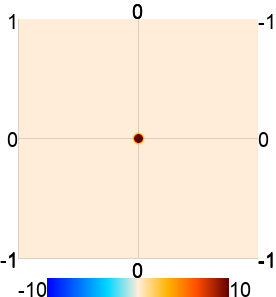

In [4]:
# We set up a map with a given geometry (a 2x2 square degrees stamp with 0.5 arcmin pixels)
shape, wcs = enmap.geometry(np.array([[-1,1],[1,-1]])*utils.degree, res=0.5*utils.arcmin)
pixarea    = enmap.pixsizemap(shape, wcs)

# Our experiment will have a Gaussian beam with FWHM=2.2 arcmin
#Omega_b is the beam solid angle for a Gaussian beam in sr
bsigma     = 2.2*utils.fwhm*utils.arcmin
Omega_b    = (np.pi / 4 / np.log(2)) * (2.2*utils.arcmin)**2

# We will put a source at the center of the map (ra=0 deg, dec=0 deg) with a flux density of 10 mJy
# signal is a map with the profile of the point source in mJy/sr
pos        = [0.0,0.0]
signal     = (10/Omega_b) * np.exp(-0.5*enmap.modrmap(shape, wcs, pos)**2/bsigma**2)

# We define a Unified Harmonic Transform (uht) object, that will take care of the
#map<->harmonic transformations for us under the hood, either using FFT or SHT.
uht        = uharm.UHT(shape, wcs)

# This is the harmonic transform of the beam in 2D (since it is Gaussian we assume symmetry around the axis)
beam       = np.exp(-0.5*uht.l**2*bsigma**2)

# We need a conversion factor between temperature units (K) and spectral radiance (Jy/sr). We assume we are observing at 90 GHz
fconv      = utils.dplanck(90e9, utils.T_cmb)/1e3 # uK -> mJy/sr

# we need to transform our signal map which is in mJy/sr to uK using the conversion factor.
signal /= fconv # this will leave our map in uK units

#Let's see the signal only map
eshow(signal,**{"range":10, "colorbar":True})

**White noise** Let's simulate white noise of 10 uK*arcmin

In [5]:
# This is the inverse variance, which is constant across pixels
ivar       = 10**-2*pixarea/utils.arcmin**2
noise      = enmap.rand_gauss(shape, wcs) * np.sqrt(1/ivar)

# we add the noise to the signal. Remember that signal is already in uK units from above
map        = signal + noise

# The analysis module contains many matched filter calculators
# In this case we use a fuction that receives a map of inverse covariances
rho, kappa = analysis.matched_filter_white(map*fconv, beam, ivar/fconv**2, uht)
flux  = rho/kappa
dflux = kappa**-0.5

print('Our measured flux is %.3f +- %.3f mJy'%(flux.at(pos)[0],dflux.at(pos)[0]))

Our measured flux is 9.893 +- 0.568 mJy


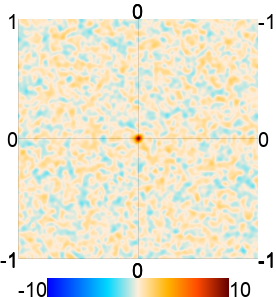

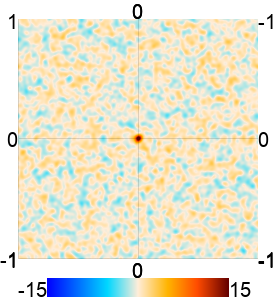

In [6]:
# we plot our flux map, and our signal/noise map
eshow(flux, **{"range":10, "colorbar":True})
eshow(flux/dflux, **{"range":15, "colorbar":True})

**Using a noise spectrum instead of a noise map**

In [7]:
# Now we define a noise spectrum instead of inputting a map. In this case we
# will still simulate white noise, so this iN spectrum is a constant value
iN = 10**-2/utils.arcmin**2

# This matched filter function receives a noise spectra as input
rho, kappa = analysis.matched_filter_constcov(map*fconv, beam, iN/fconv**2, uht)
flux  = rho/kappa # kappa just a number in this case, and hence the errorbar will also be a single number
dflux = kappa**-0.5

print('Our measured flux is %.3f +- %.3f mJy'%(flux.at(pos)[0],dflux))

Our measured flux is 9.893 +- 0.568 mJy


**Using both a noise map and noise spectrum** This method supports a noise model given by $N^{-1} = \sqrt{\rm{(ivar)}} C^{-1} \sqrt{\rm{(ivar)}}$, where $\rm{(ivar)}$ is the inverse variance and $C^{-1}$ is the inverse of the noise spectrum. This represents correlated noise described by iC that's modulated spatially by ivar.

In [8]:
# The noise units are only in ivar, so the white noise spectrum is just a dimensionless 1
iN = 1

# This matched filter function receives a noise spectra and a noise map as inputs
rho, kappa = analysis.matched_filter_constcorr_lowcorr(map*fconv, beam, ivar/fconv**2, iN, uht)
flux  = rho/kappa
dflux = kappa**-0.5

print('Our measured flux is %.3f +- %.3f mJy'%(flux.at(pos)[0],dflux.at(pos)[0]))

Our measured flux is 9.893 +- 0.568 mJy


**1/f noise** Let's try a more realistic 1/f noise now

In [9]:
# base noise depth of 10 uK * arcmin, this is the base of white noise
ivar  = 10**-2*pixarea/utils.arcmin**2
# spatial modulation with 1 arcmin wavelength horizontal sine wave
# this represents different observing depths in different parts of the sky like a real experiment
ivar *= (1+0.9*np.sin(enmap.posmap(shape, wcs)[0]/(1*utils.arcmin)))

# We model the noise power spectrum as a 1/f with l_knee=2000, alpha_knee=-3.
# We only include the 1/f part, the white noise part is done separately
l_arr = np.arange(8000+1)
N    = (10**2 * utils.arcmin**2) * ( ((l_arr+0.5)/2000)**-3 ) # this is for generating the realization
iN   = 1/(1 + ((uht.l+0.5)/2000)**-3) # this is in 2D, to use in the matched filter
# we generate a 1/f with a 10 uK*arcmin base white noise
noise_oof = enmap.rand_map(shape, wcs, N, spin=0)

# we coadd the white noise and the 1/f noise
noise_atm = enmap.rand_gauss(shape, wcs)*np.sqrt(1/ivar) + noise_oof

map = signal + noise_atm

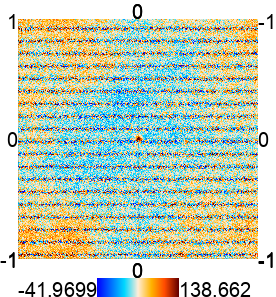

In [10]:
# Let's look at how the total map looks like
eshow(map, **{"colorbar":True})

Our measured flux is 11.891 +- 0.692 mJy


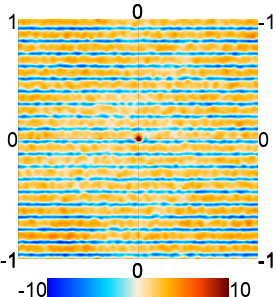

In [11]:
# We estimate the flux, using the noise theory spectrum and the ivar map
rho, kappa = analysis.matched_filter_constcorr_lowcorr(map*fconv, beam, ivar/fconv**2, iN, uht)
flux  = rho/kappa
dflux = kappa**-0.5
print('Our measured flux is %.3f +- %.3f mJy'%(flux.at(pos)[0],dflux.at(pos)[0]))

eshow(flux, **{"range":10, "colorbar":True})

**Measure the spectrum empirically** Now instead of a model iN for the noise spectrum, we will measure it directly from the map

In [14]:
# We measure the spectra from the map. First, we will ignore the point source in the center and include it in the spectra calculation
iNemp  = 1/(np.mean(np.abs(uht.map2harm(map*ivar**0.5))**2,0) / map.pixsize())

rho, kappa = analysis.matched_filter_constcorr_dual(map*fconv, beam, ivar/fconv**2, iNemp, uht)
flux  = rho/kappa
dflux = kappa**-0.5
print('Our measured flux is %.3f +- %.3f mJy'%(flux.at(pos)[0],dflux.at(pos)[0]))

Our measured flux is 11.318 +- 0.661 mJy


In [15]:
# We can also mask the point source at the center

#helper function to create a circular mask
def cmask(dy, dx, center=None, radius=None):
    if center is None: # use the middle of the image
        center = (int(dx/2), int(dy/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], dx-center[0], dy-center[1])
    Y, X = np.ogrid[:dy, :dx]
    radmap = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    mask = radmap <= radius
    return np.logical_not(mask)
dx,dy = map.shape

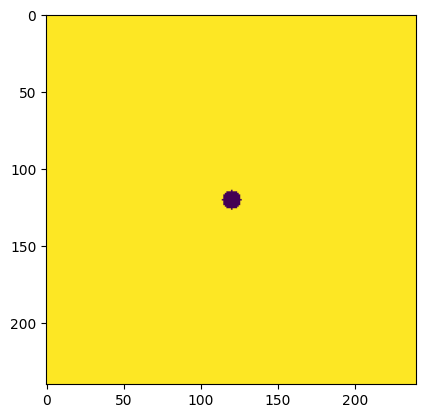

In [16]:
# We create a mask with a radius of 6 pixels around the center
mask = cmask(dy,dx, radius=6)

# Let's look at the mask
pl.imshow(mask)

In [17]:
# We measure the spectra from the map like before. This time we multiply by the mask
iNemp  = 1/(np.mean(np.abs(uht.map2harm(map*mask*ivar**0.5))**2,0) / map.pixsize())

rho, kappa = analysis.matched_filter_constcorr_dual(map*fconv, beam, ivar/fconv**2, iNemp, uht)
flux  = rho/kappa
dflux = kappa**-0.5
print('Our measured flux is %.3f +- %.3f mJy'%(flux.at(pos)[0],dflux.at(pos)[0]))

Our measured flux is 11.402 +- 0.656 mJy


**Second example** Our second example will be simulating multiple point sources in a big map, and stack them. We will generate random coordinates where we place the sources and assume that we are observing the same source with an "absolute" flux of 3 mJy at different coordinates and at different random distances. The measured fluxes will change depending on the distance to each source. This cell may take ~5 min to compute.

In [18]:
Nsources = 100

# We generate a big map. We will make a stripe 60 degrees wide by 20 degrees tall
shape, wcs = enmap.geometry(np.array([[-10,30],[10,-30]])*utils.degree, res=0.5*utils.arcmin)
pixarea    = enmap.pixsizemap(shape, wcs)
signal     = enmap.zeros(shape, wcs=wcs)

# We will store the random coordinates and distances for each source.
ra_sources = np.zeros(Nsources)
dec_sources = np.zeros(Nsources)
dist_sources = np.zeros(Nsources)

for n_source in range(Nsources):
  # this is not the proper way of generating uniformly sampled sources in the surface of the sphere, but for our purposes it is fine
  pos        = np.array([np.random.uniform(-10,10), np.random.uniform(-30,30)]) * utils.degree
  # The source will have a flux of 3 mJy at a distance of 1, and we generate random distances from 0.5 to 20.
  dist       = np.random.uniform(0.5, 20)
  signal     += 3 * (1/dist)**2 * (1/Omega_b) * np.exp(-0.5*enmap.modrmap(shape, wcs, pos)**2/bsigma**2)
  # Save to arrays
  ra_sources[n_source] = pos[1]
  dec_sources[n_source] = pos[0]
  dist_sources[n_source] = dist

# we need to transform our signal map which is in mJy/sr to uK using the conversion factor.
signal /= fconv # this will leave our map in uK units

In [19]:
# Let's generate a 1/f noise

# base noise depth of 10 uK * arcmin, this is the base of white noise
ivar  = 10**-2*pixarea/utils.arcmin**2
# spatial modulation with 5 arcmin wavelength horizontal sine wave
# this represents different observing depths in different parts of the sky like a real experiment
ivar *= (1+0.9*np.sin(enmap.posmap(shape, wcs)[1]/(5*utils.arcmin)))

# We model the noise power spectrum as a 1/f with l_knee=2000, alpha_knee=-3.
# We only include the 1/f part, the white noise part is done separately
l_arr = np.arange(8000+1)
N    = (10**2 * utils.arcmin**2) * ( ((l_arr+0.5)/2000)**-3 ) # this is for generating the realization
# we generate a 1/f with a 10 uK*arcmin base white noise
noise_oof = enmap.rand_map(shape, wcs, N, spin=0)

# We multiply by ivar to generate our final noise realization
noise_atm = enmap.rand_gauss(shape, wcs)*np.sqrt(1/ivar) + noise_oof

map = signal + noise_atm

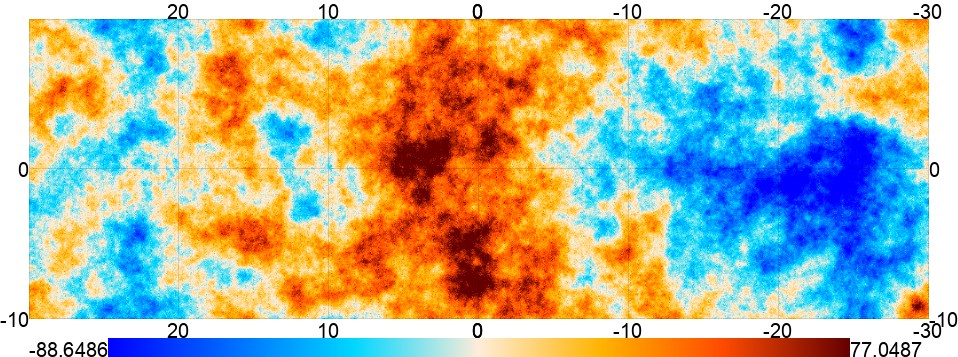

In [20]:
# Let's look at the map
params = {"colorbar":True, "downgrade":8, "mask":0, "ticks":10}
eshow(map, **params)

In [21]:
# Let's apply a matched filter and look at the flux map
uht        = uharm.UHT(shape, wcs)
beam       = np.exp(-0.5*uht.l**2*bsigma**2)
iN   = 1/(1 + ((uht.l+0.5)/2000)**-3) # this is in 2D, to use in the matched filter

rho, kappa = analysis.matched_filter_constcorr_dual(map*fconv, beam, ivar/fconv**2, iN, uht)

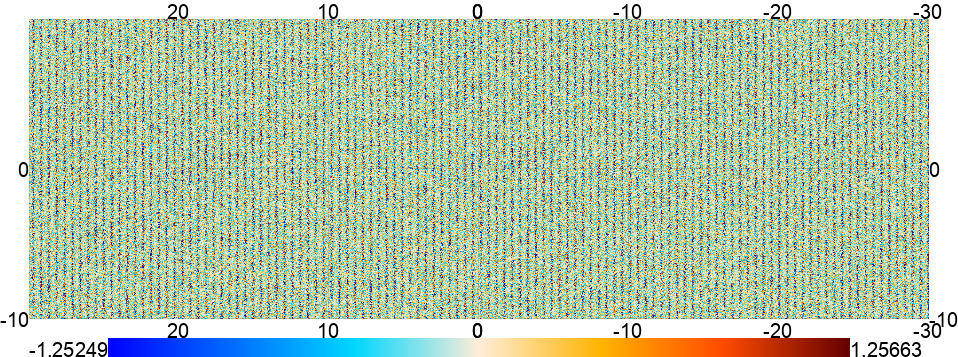

In [22]:
# Let's look at the flux map
params = {"colorbar":True, "downgrade":8, "mask":0, "ticks":10}
eshow(rho / kappa, **params)

As you can see, the sin pattern we included to simulate spatial modulation is visible. Also, point sources are not easy to see, however when we stack their positions, they will be obvious to see.

**Explanation of stacking** We model the flux for source $i$ as $f_i = a R_i + n_i$, where $n_i$ is the noise of the flux, $R_i$ is the weight between transient $i$ and the reference transient, and $a$ is the detection statistic we are optimizing for (i.e. the coadded flux). In our case, we are assuming we are stacking the same type of source (with a fixed luminosity) but flux changing with the square distance law as these objects are found closer or further away. The inverse covariance of $f_i$ is $\kappa_i$. The maximum solution of this equation is given by
\begin{equation}
\hat{a} = \frac{\sum_i R_i \kappa_i f_i}{\sum_i R_i^2 \kappa_i}
\end{equation}
for $a$. This estimator has inverse covariance $A$ given by
\begin{equation}
\hat{A} = \sum_i R_i^2 \kappa_i \text{.}
\end{equation}
In our particular case, the weight $R_i$ is proportional to the inverse distance squared to transient $i$.

In [23]:
# We define an empty 2x2 degrees empty stamp, and we will project the cutouts from the big map into this empty stamp.

shape_stack, wcs_stack = enmap.geometry(np.array([[-1,1],[1,-1]])*utils.degree, res=0.5*utils.arcmin)
rho_stack     = enmap.zeros(shape_stack, wcs=wcs_stack)
kappa_stack   = enmap.zeros(shape_stack, wcs=wcs_stack)

for n_source in range(Nsources):
  pos = np.array([dec_sources[n_source],ra_sources[n_source]]) # this coordinates are already in radians

  # we cutout a rho and kappa stamp around the source
  rho_i = reproject.thumbnails(rho, np.reshape(pos,(1,2)), oshape=shape_stack, owcs=wcs_stack, r=1*utils.degree)[0]
  kappa_i = reproject.thumbnails(kappa, np.reshape(pos,(1,2)), oshape=shape_stack, owcs=wcs_stack, r=1*utils.degree)[0]

  # this is the ratio with respect to the reference at distance 1.
  # We will assume our measured distance is the correct distance plus a random 4% error
  R_i = (1 / (dist_sources[n_source]*(1+np.random.normal(scale=0.04))))**2

  rho_stack += R_i * kappa_i * rho_i / kappa_i
  kappa_stack += R_i**2 * kappa_i
a = rho_stack / kappa_stack
da = kappa_stack ** -0.5

Our measured stacked flux is 2.722 +- 0.408 mJy, which is a 6.7 sigma detection


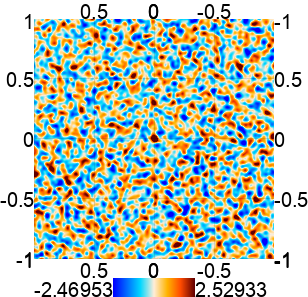

In [24]:
# We measure the flux from the stacked sources at the center of the map, and we plot the S/N
pos = [0,0]
print('Our measured stacked flux is %.3f +- %.3f mJy, which is a %.1f sigma detection'%(a.at(pos)[0],da.at(pos)[0],a.at(pos)[0]/da.at(pos)[0]))

params = {"colorbar":True, "mask":0, "ticks":0.5}
eshow(a / da, **params)

Even though the individual sources are barely visible in the big map, if we have a rough idea of where they are and how much flux we should expect from them (e.g. we know their distance squared), we can stack them and recover their expected flux.